In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as smf

def simulate_random_walks(num_trials, drift1, drift2, alpha, pop_var, dependent=False):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + step1

        # Introduce randomness to dimensionality
        if pop_var is True:
            dim = 2 * np.random.sample() -1
        else: 
            dim = 1

        if dependent:
            # Make walk2 dependent on the previous timestep of walk1
            walk2[step] = walk2[step - 1] + drift2 + (alpha*dim) * walk1[step - 1] + step2
        else:
            walk2[step] = walk2[step - 1] + drift2 + step2
            
    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation

def random_walks_with_intervention(num_trials, intervention, gain, drift1, drift2):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + intervention[step-1] * gain + step1

        walk2[step] = walk2[step - 1] + drift2 + intervention[step-1] * gain + step2

    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation


def simulate_ar(n, phi, sigma):
    """Simulate autoregressive process

    Args:
        n (int): number of trials
        phi (_type_): _description_

    Returns:
        _type_: _description_
    """
    ar_process = [0]
    for _ in range(n):
        ar_process.append(phi * ar_process[-1] + np.random.normal(0, sigma))
    return ar_process[1:]

def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation
    
    Args: 
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y 
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns: 
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''
    
    sobel = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    aroian  = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2) + (se_b**2) *(se_a**2)) #SE2 for arioni test
    t = (a*b) / aroian
    n = 1000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval

def mediation_tests(behavioural, neural, intervention):
    intervention = pd.DataFrame({'Intercept':np.ones(len(intervention)),'X':intervention})
    regression_a= smf.OLS(neural,intervention).fit()

    neural = pd.DataFrame({'Intercept':np.ones(len(neural)),'X':neural})
    regression_b = smf.OLS(behavioural, neural).fit()

    return regression_a, regression_b

def performMediation(num_tests, num_phis, num_trials, staticIntervention):
    """Simulate mediation analysis for different values of phi with interventions as static or variable

    Args:
        num_tests (_type_): _description_
        num_phis (_type_): _description_
        num_trials (_type_): _description_
        staticIntervention (_type_): _description_
    """
    phis = np.linspace(.7, 1, num_phis)
    num_significant_mediator = np.zeros(num_phis)
    num_significant1 = np.zeros(num_phis)
    num_significant2 = np.zeros(num_phis)

    num_significant_correlation = np.zeros(num_phis)
    num_trials = np.linspace(num_trials, num_trials, 1)
    mu, sigma = 0, 1  # Mean and standard deviation

    for num_trial in num_trials:

        num_trial = int(num_trial)
        ax = plt.figure()
        
        for num, phi in enumerate(phis):
            mediation_effects = np.zeros(num_tests)
            direct1_effects = np.zeros(num_tests)
            direct2_effects = np.zeros(num_tests)
            correlation_effects = np.zeros(num_tests)

            for test in range(num_tests):

                # Step 1: Generate three independent random walks
                
                if staticIntervention is True:
                    intervention = np.random.normal(mu, sigma, num_trial)
                else:
                    intervention = simulate_ar(n = num_trial, phi = phi, sigma = sigma)
                    
                neural= simulate_ar(n = num_trial, phi = phi, sigma = 1)
                behavioural = simulate_ar(n = num_trial, phi = phi, sigma = 1)

                # Step 2: Calculate Sobel test statistics
                # Calculate the direct effect of intervention on neural
                _, p_value_neural = ttest_ind(intervention, neural)

                # Calculate the effect of intervention on behaviour
                _, p_value_behaviour = ttest_ind(behavioural, intervention)

               # Calculate the effect of neural on behaviour
                _, p_value_corr = ttest_ind(behavioural, neural)


                # Step 3: Perform the Sobel test for mediation significance
                regression_a, regression_b = mediation_tests(behavioural, neural, intervention)

                t, p_value_sobel = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])

                # Store p values for computing FP rate
                mediation_effects[test] = p_value_sobel
                direct1_effects[test] = p_value_neural
                direct2_effects[test] = p_value_behaviour
                correlation_effects[test] = p_value_corr

            # Compute FP rate for correlations and mediations
            num_significant1[num] = np.sum(direct1_effects < .05)
            num_significant2[num] = np.sum(direct2_effects < .05)
            num_significant_correlation[num] = np.sum(correlation_effects < .05)
            num_significant_mediator[num] = np.sum(mediation_effects < .05)


        # Plot proportion significant correlations/mediations by Phi value
        plt.plot(num_significant1/num_tests)
        plt.xlabel('Number of Trials')
        plt.xticks([0,25], labels = [0.7, 1])
        plt.plot(num_significant_mediator/num_tests)
        plt.xlabel('Phi')
        plt.ylabel('Proportion false positive')
        plt.plot(num_significant_correlation/num_tests)
        plt.plot(num_significant2/num_tests)
        plt.ylim([-.01, 1])

def simulatePvalues(staticIntervention, causal, drift1, drift2, 
                    num_experiments, gain, num_trials, phi, sigma):
    """_summary_

    Args:
        staticIntervention (_type_): _description_
        drift (_type_): _description_
        num_experiments (_type_): _description_
        num_trials (_type_): _description_
        phi (_type_): _description_
    """
    mu = 0
    pvals = np.zeros(num_experiments)
    coeffs = np.zeros(num_experiments)
    r2 = np.zeros(num_experiments)

    for i in range(num_experiments):
        if staticIntervention is True:
            intervention = np.random.normal(mu, sigma, num_trials)
        else:
            intervention = simulate_ar(n = num_trials, phi = phi, sigma = sigma)
        
        if causal is True:
            neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = drift1, drift2 = drift2, gain = gain)
            #neural, behavioural, _ = simulate_random_walks(num_trials, drift1 = np.mean(intervention)/10, 
                                                        #drift2 = np.mean(intervention)/10, alpha = 0, pop_var = False, dependent=False)
        else:
            neural, behavioural, _ = simulate_random_walks(num_trials, drift1 = drift1, 
                                                        drift2 = drift2, alpha = 0, pop_var = False, dependent=False)
            #neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = 0, drift2 = 0)


        regression_a, regression_b = mediation_tests(behavioural, neural, intervention)
        coeffs[i] = regression_a.params[1]
        r2[i] = regression_a.rsquared
        t, pvals[i] = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])
    fig, axs = plt.subplots(2,2, figsize = (15,15))

    axs[0,0].hist(pvals)
    axs[0,0].set_title(f'P val distribution: static intervention = {staticIntervention}, causal = {causal}, phi = {phi}')
    axs[0,0].set(xlabel="pval", ylabel="count")

    axs[0,1].plot(intervention)
    axs[0,1].plot(neural)
    axs[0,1].plot(behavioural)
    axs[0,1].set_title(f'Sample experiment: static intervention = {staticIntervention}, causal = {causal}, phi = {phi}')
    axs[0,1].set(xlabel="time", ylabel="AU")

    #axs[1,0].hist(coeffs)

    #axs[1,0].scatter(coeffs, r2)
    bin_means, bin_edges, binnumber = stats.binned_statistic(coeffs, r2)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axs[1,0].set_title('Intervention --> Behaviour Regression coefficient vs R-Squared')
    axs[1,0].set(xlabel="Regression coefficient", ylabel="R-squared")
    axs[1,0].plot(bin_centers, bin_means)

    #axs[1,1].scatter(pvals, r2)
    bin_means, bin_edges, binnumber = stats.binned_statistic(pvals, r2)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    plt.plot(bin_centers, bin_means)

    axs[1,1].set_title('Intervention --> Behaviour p-value vs R-squared')
    axs[1,1].set(xlabel="p-value", ylabel="R-squared")


KeyboardInterrupt: 

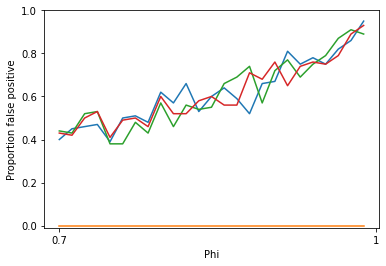

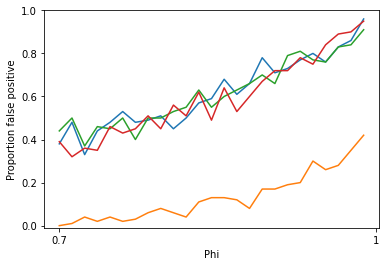

<Figure size 432x288 with 0 Axes>

In [15]:
performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = True)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\100_trials_static_true', format = 'svg')

performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = False)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\100_trials_static_false', format = 'svg')

performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = True)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\1000_trials_static_true', format = 'svg')

performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = False)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\1000_trials_static_false', format = 'svg')


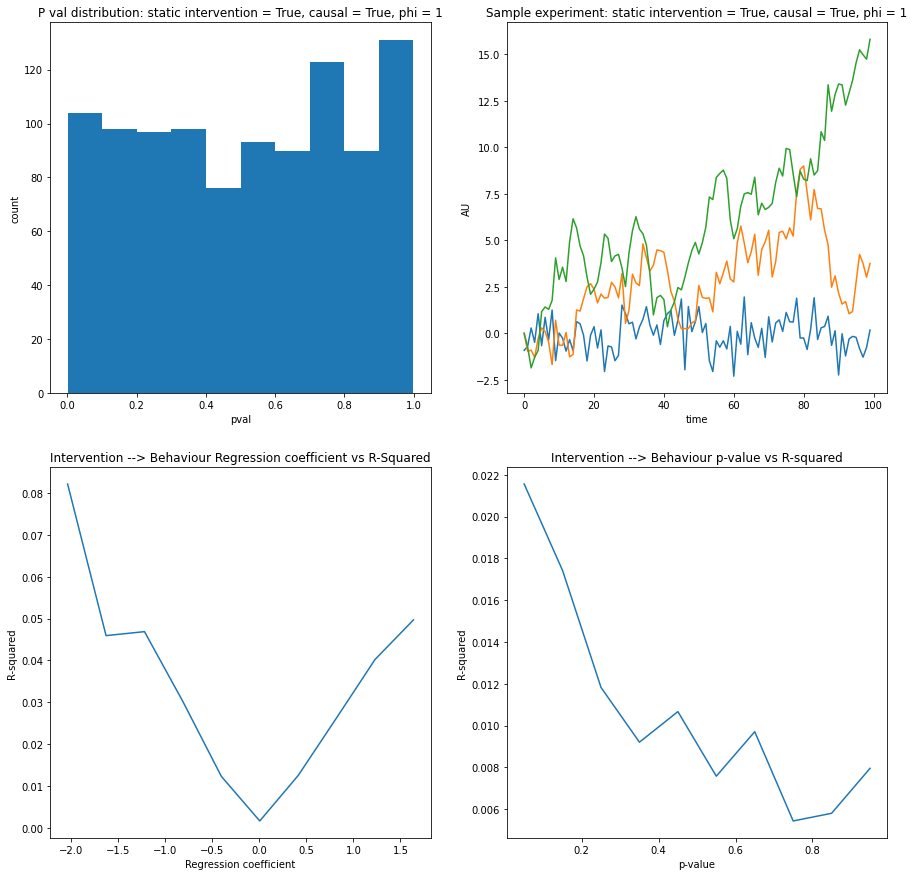

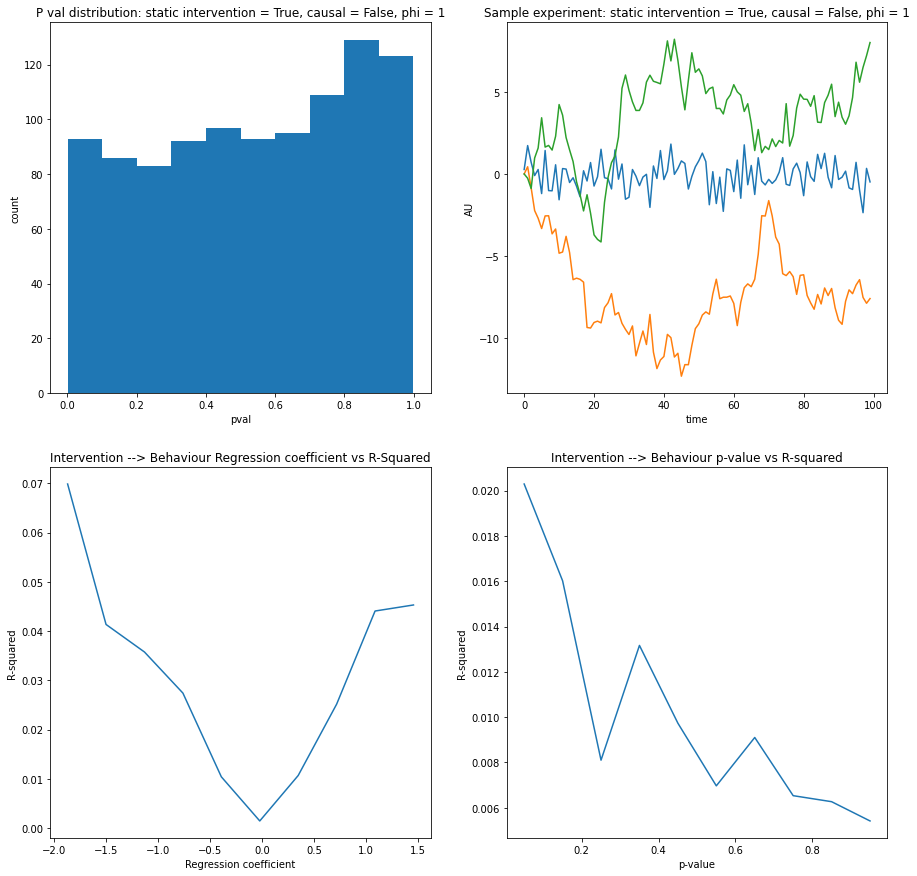

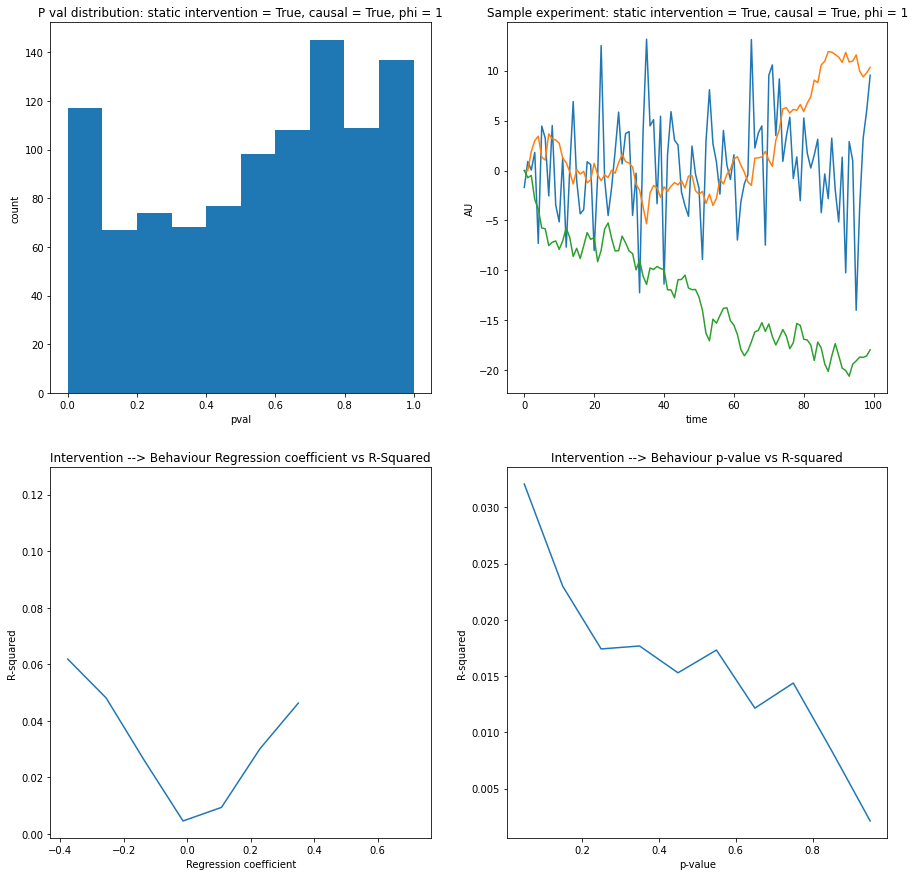

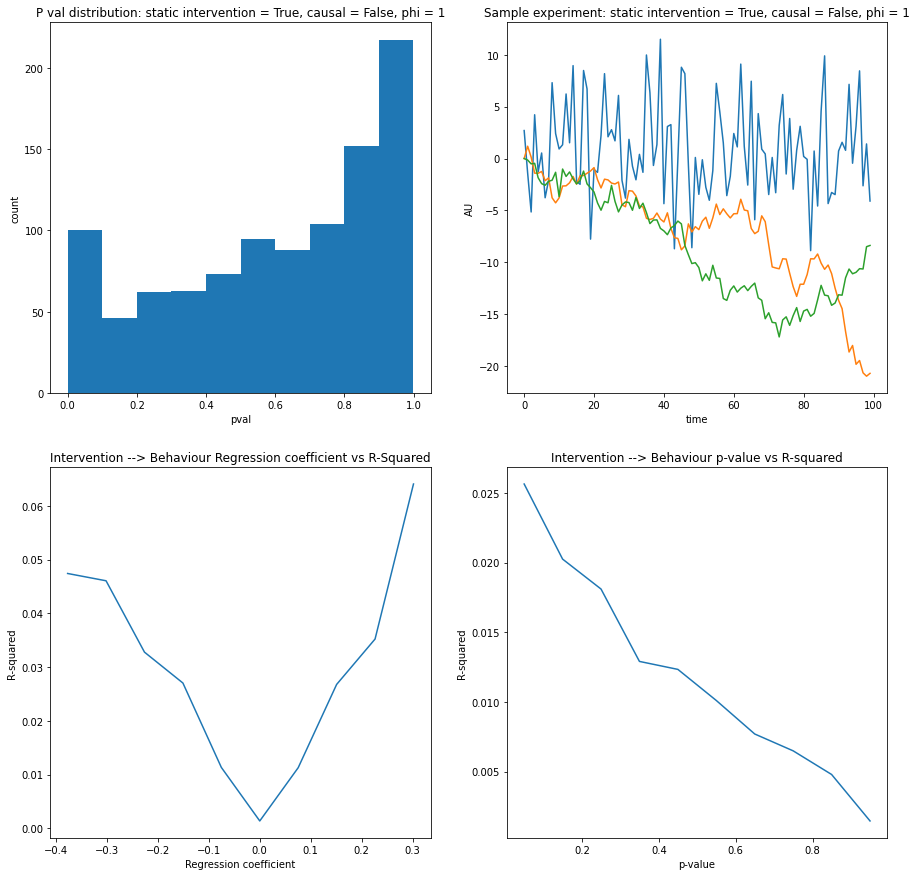

In [109]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = True, causal = True, drift1 = 0, drift2 = 0, sigma = 1,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)

simulatePvalues(staticIntervention = True, causal = False, drift1 = 0, drift2 = 0, sigma = 1,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)

## Increase noise
simulatePvalues(staticIntervention = True, causal = True, drift1 = 0, drift2 = 0, sigma = 5,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)

simulatePvalues(staticIntervention = True, causal = False, drift1 = 0, drift2 = 0, sigma = 5,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)


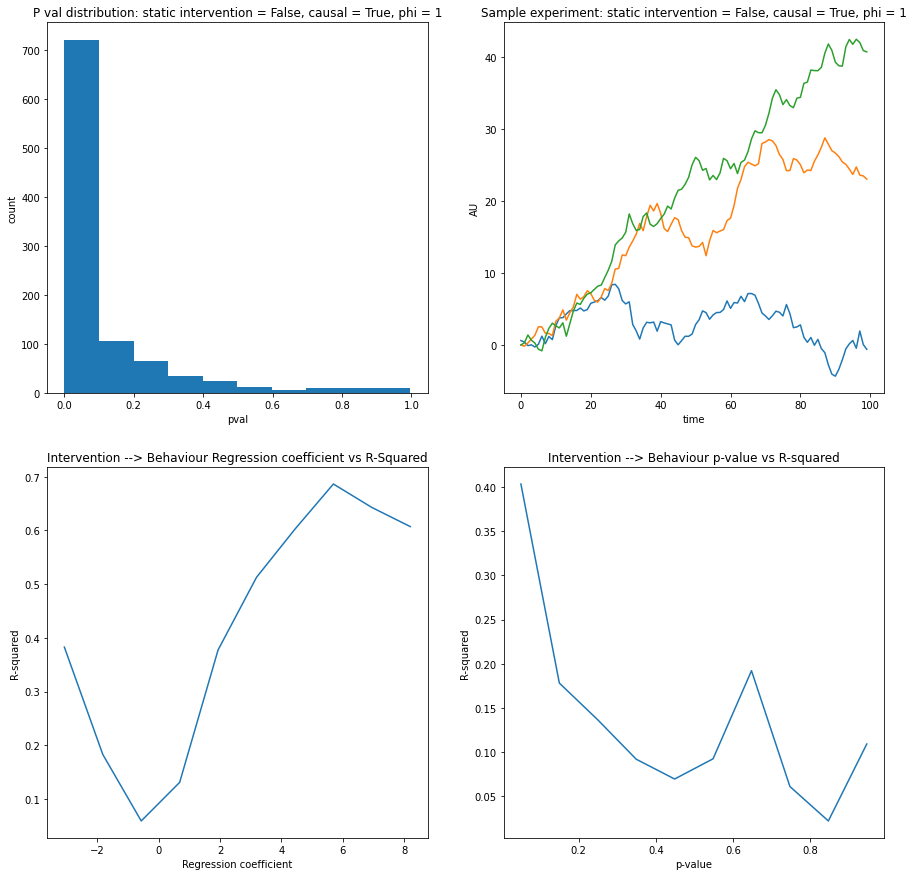

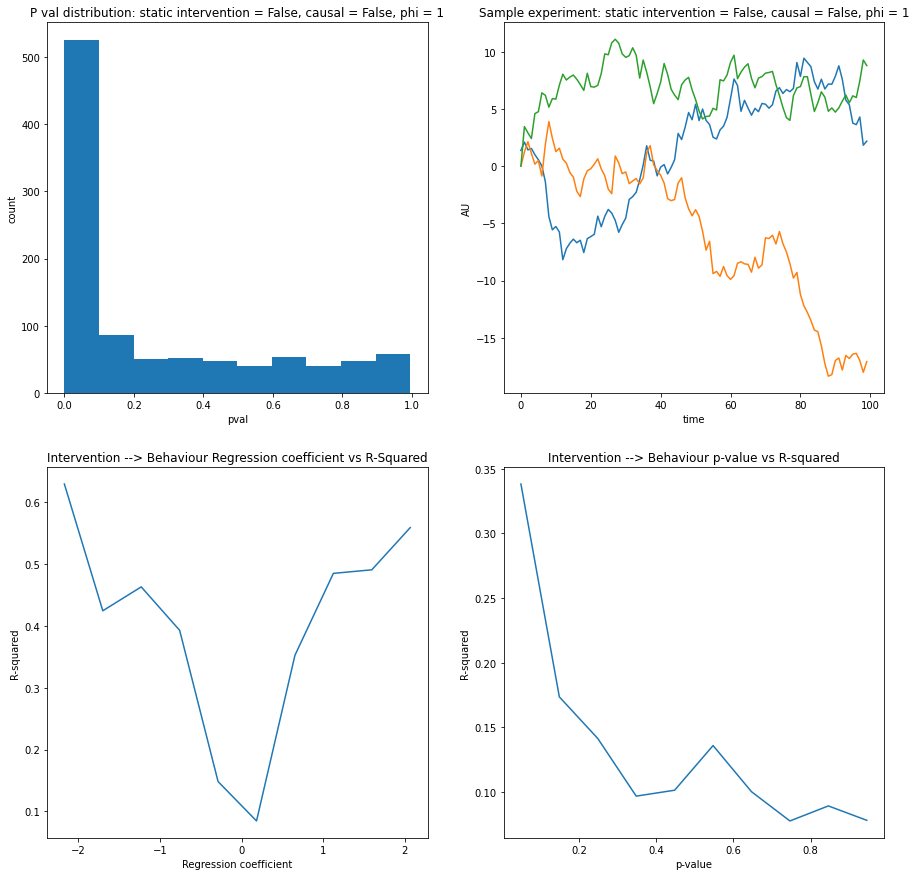

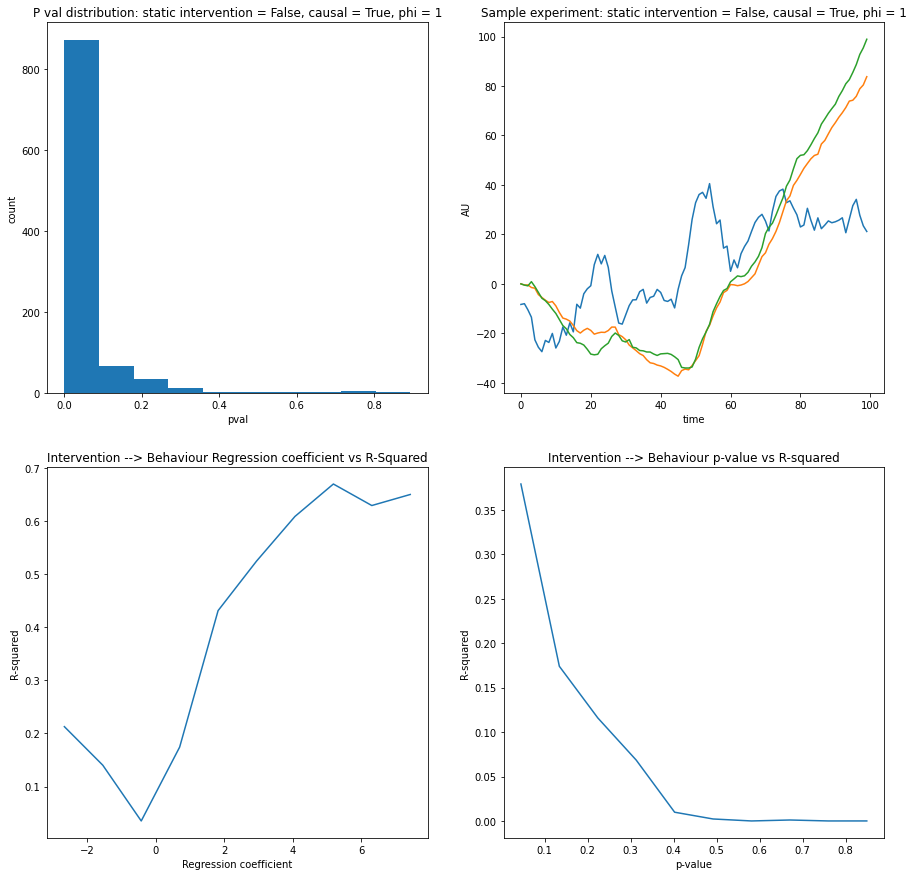

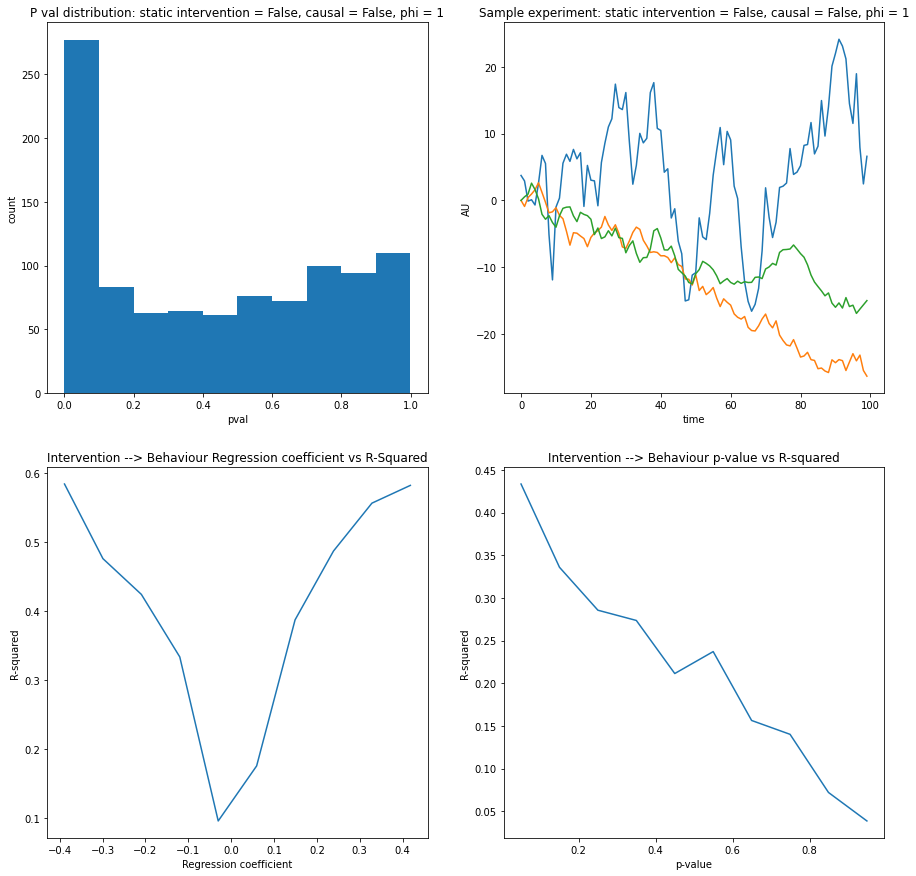

In [113]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = False, causal = True, drift1 = 0, drift2 = 0, sigma = 1,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)
simulatePvalues(staticIntervention = False, causal = False, drift1 = 0, drift2 = 0, sigma = 1,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)
simulatePvalues(staticIntervention = False, causal = True, drift1 = 0, drift2 = 0, sigma = 5,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)
simulatePvalues(staticIntervention = False, causal = False, drift1 = 0, drift2 = 0, sigma = 5,
                num_experiments = 1000, gain = .1, num_trials = 100, phi = 1)

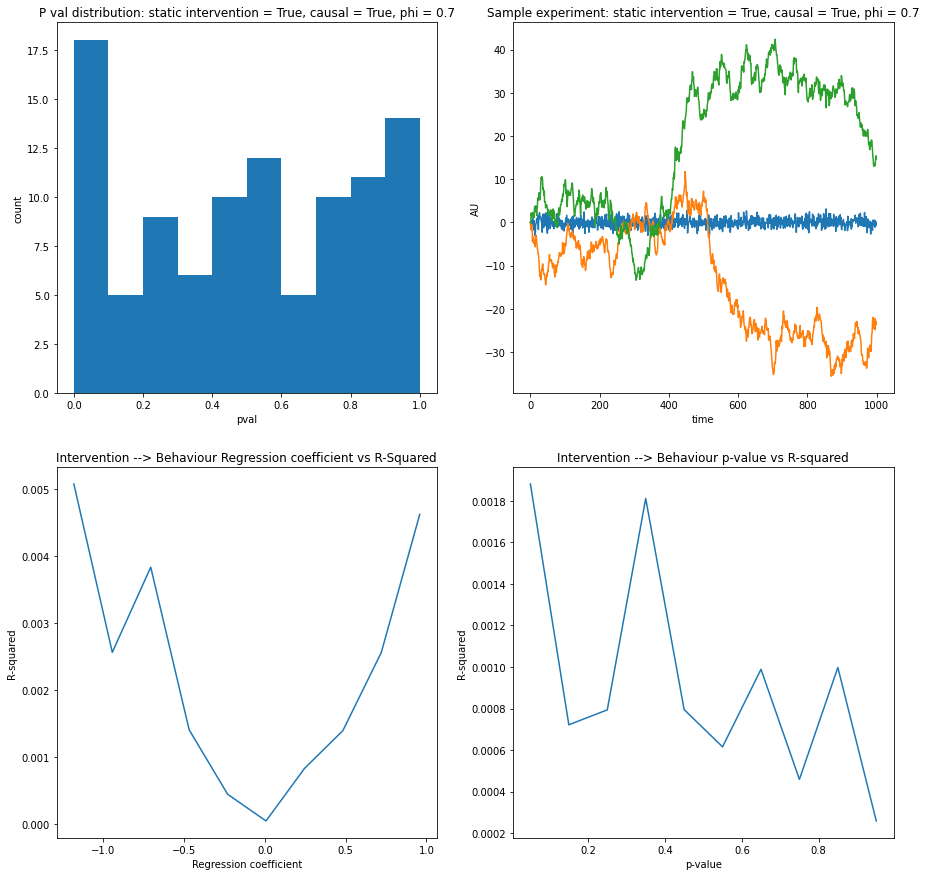

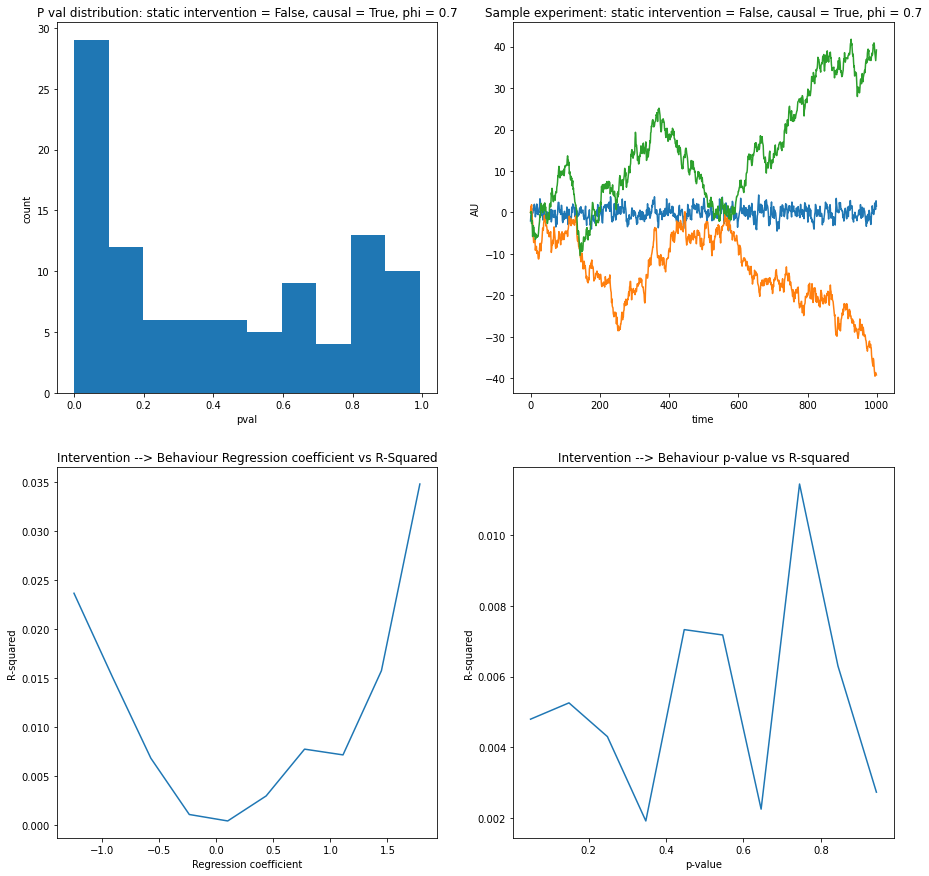

In [102]:
simulatePvalues(staticIntervention = True, num_experiments=100, drift1 = 0, drift2 = 0, sigma = 1,
                num_trials = 1000, gain = .01, phi = .7, causal = True)

simulatePvalues(staticIntervention = False, num_experiments=100, drift1 = 0, drift2 = 0, sigma = 1,
                 num_trials = 1000, gain = .01, phi = .7, causal = True)


Text(0.5, 1.0, 'Dynamic Intervention, Independent, Low Phi')

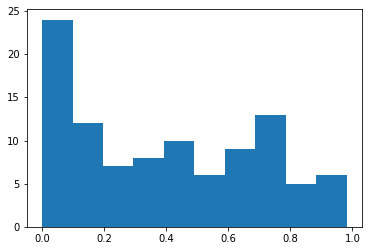

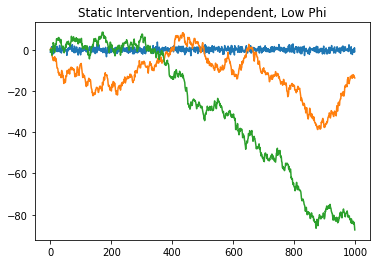

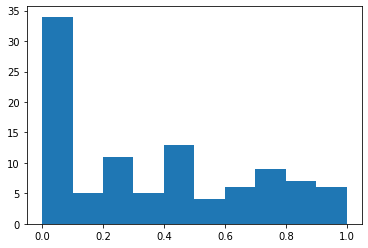

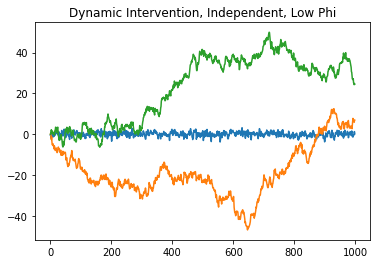

In [287]:
simulatePvalues(staticIntervention = True, num_experiments=100, drift1 = 0, drift2 = 0, 
                num_trials = 1000, phi = .5, gain = .01, causal = False)
plt.title('Static Intervention, Independent, Low Phi')
simulatePvalues(staticIntervention = False, num_experiments=100, drift1 = 0, drift2 = 0, 
                num_trials = 1000, phi = .5, gain = .01, causal = False)
plt.title('Dynamic Intervention, Independent, Low Phi')

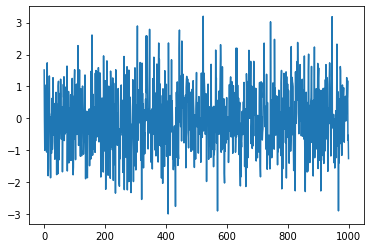

In [22]:
## Plot white noies for figure making

mean = 0
std = 1 
num_samples = 1000
samples = np.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\whitenoise', format = 'svg')